# What correlates to starts

This analysis is looking at what usage parameters correlates to program starts.

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd
import sys
import pytz
import datetime
pacific = pytz.timezone('US/Pacific')
import pylab
pylab.rcParams['figure.figsize'] = (12,8)

sys.path.append('/Users/dane/src/datatools')

## Clean and filter data

In [28]:
stdf = pd.read_excel('/Users/dane/src/datatools/ipy/notebooks/starts_correlation/data/lds_starts.xlsx')
stdf.head()

,date,starts,all_sessions,has commands
0,2016-12-16,260,316,211
1,2016-12-15,262,215,121
2,2016-12-14,227,254,174
3,2016-12-13,166,252,169
4,2016-12-12,71,89,62


In [29]:
# resort dates and get date range and localize times
######stdf.date = stdf.date.apply(lambda x: pacific.localize(x))
stdf['day'] = stdf.date.apply(lambda x: x.strftime('%Y-%m-%d'))
stdf.sort_index(by='date', inplace=True)
print('Date Range: ' + str(stdf.day.min()) + ' to ' + str(stdf.day.max()))
stdf.head()

Date Range: 2016-11-01 to 2016-12-16


,date,starts,all_sessions,has commands,day
45,2016-11-01,135,116,66,2016-11-01
44,2016-11-02,106,139,82,2016-11-02
43,2016-11-03,151,117,78,2016-11-03
42,2016-11-04,136,145,69,2016-11-04
41,2016-11-05,146,112,65,2016-11-05


In [30]:
sdf = pd.read_pickle('/Users/dane/dropbox/work/datafiles/sessions.df')

# cleanup the data: 
#   - keep only dates in stdf, remove features, convert dates to pst
#   - add date column
#   - remove internal sessions
sdf['day'] = sdf.added.apply(lambda a: a.astimezone(pacific).strftime('%Y-%m-%d'))
sdf.drop(['features', 'added'], axis=1, inplace=True)
sdf = sdf[sdf.user_type != 'internal']
sdf = sdf[(sdf.day >= stdf.day.min()) & (sdf.day <= stdf.day.max()) ]
print('Date Range: ' + str(sdf.day.min()) + ' to ' + str(sdf.day.max()))
sdf.head()

Date Range: 2016-11-01 to 2016-12-16


,id,build_number,user,company,serial_num,has_commands,project_id,user_type,disp_name,user_name,custid,runtime,state,username,name,day
131,38249,8263,Cust# 62,Gigacom Inc.,51957,False,None,customer,Matthew Bell at Gigacom,Mathew () id=62,62,0,C,Mathew (),None,2016-11-16
548,48855,8275,Cust# 8905,Qorvo - FL,52989,True,None,customer,Pedro Zayas at Qorvo,pzayas id=8905,8905,5390,D,pzayas,None,2016-12-12
562,41452,8263,Cust# 2398,Kathrein-Werke KG,52975,False,None,customer,None,bauerj id=2398,2398,251734,D,bauerj,None,2016-11-25
645,46921,8275,Cust# 8905,Qorvo - FL,52989,False,None,customer,Sebastian Tanuz at Qorvo,stanuz id=8905,8905,7239,D,stanuz,None,2016-12-08
811,39387,8263,Cust# 8905,Qorvo - FL,52989,False,None,customer,None,ms031339 id=8905,8905,0,C,ms031339,None,2016-11-18


In [ ]:
sddf = pd.read_pickle('/Users/dane/Dropbox/work/datafiles/sessiondata.df')

# cleanup data
#   - remove user, machine, username, sn, project_id, build since these are all in session
#   - only keep sd records for sessions we've kept
sddf.drop(['user', 'machine', 'username', 'project_id', 'user_type'], axis=1, inplace=True)
print(len(sddf))
sddf = sddf[sddf.session_id.isin(sdf.id) ]
print(len(sddf))
sddf.head()

## Test the data

In [31]:
# Sum of session counts should match
print('The total number of sessions in start spreadsheet is: {}'.format(stdf.all_sessions.sum()))
print('The total number of sessions is: {}'.format(sdf.id.count()))

The total number of sessions in start spreadsheet is: 6768
The total number of sessions is: 6871


This is a little off but I'm not sure what timezone settings I used in the spreadsheet so it's possible that is the cause of the error.

## Session based statistics

### Looking at the number of commands per session

For this we will only keep the sessions with commands.

In [32]:
df = sdf[sdf.has_commands==True][['id', 'custid', 'runtime', 'day']]
df.head()

,id,custid,runtime,day
548,48855,8905,5390,2016-12-12
1249,32864,10730,24140,2016-11-03
1373,40350,8905,786,2016-11-22
1387,39903,3597,0,2016-11-21
2081,50649,8905,0,2016-12-15


In [85]:
cnt_by_session = sddf[sddf.category=='Command'].groupby('session_id').sum()

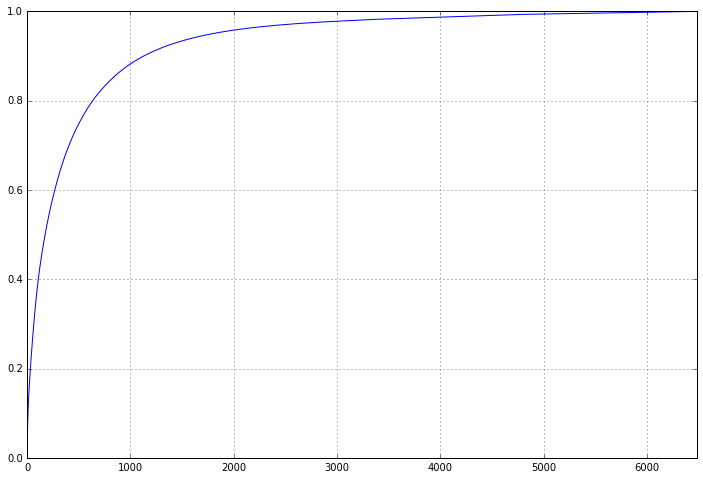

In [75]:
count_cumsum = cnt_by_session.sort_index(by='count', ascending=False)['count'].cumsum()/cnt_by_session['count'].sum()
x = count_cumsum
x.index = np.arange(len(x))
x.plot()

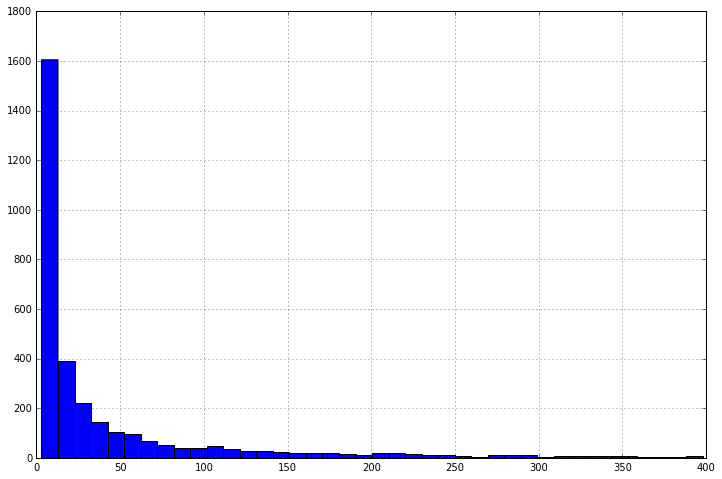

In [79]:
cbs = cnt_by_session[(cnt_by_session['count'] > 2) & (cnt_by_session['count'] < 400)]
cbs['count'].hist(bins=40)
plt.show()

### Commands per day

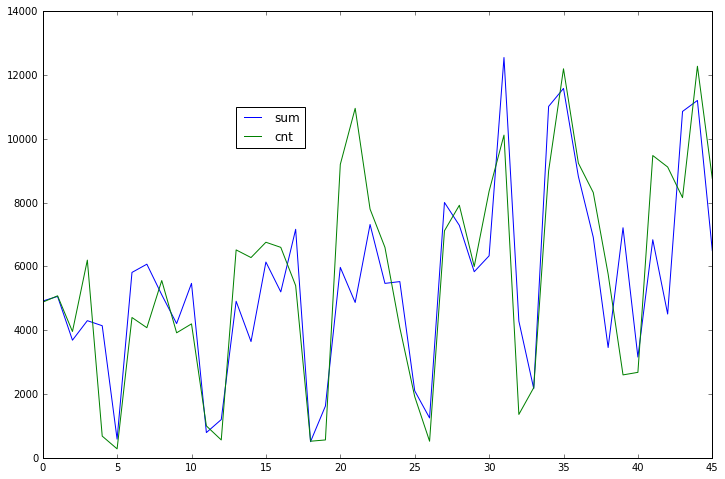

In [134]:
# need add the command count to session df
x=sdf
x.index = x['id']  # need to set the index to the session id
x['cmd_cnt'] = cnt_by_session['count']  # merge the command count in
cmds_by_day = x.groupby('day').cmd_cnt.sum()
sess_by_day = x.groupby('day').cmd_cnt.count()
a = cmds_by_day
a.index = np.arange(len(a))
plt.plot(a)
b = sess_by_day * 40

b.index = np.arange(len(b))
plt.plot(b)
plt.legend(['sum', 'cnt'], bbox_to_anchor=[0.4,0.8])

Scaling up the number of sessions we see that the session count correlates quite well with the total number of commands on a daily basis.

day
2016-11-01    122
2016-11-02    127
2016-11-03     99
2016-11-04    155
2016-11-05     17
Name: cmd_cnt, dtype: int64